# The GLM, part 3: inference
In this notebook, we'll continue with the GLM, focusing on statistical tests (i.e., inference) of parameters.

In the last tutorial, you learned how to estimate parameters of the GLM and how to interpret them. This week, we'll focus on statistical inference of those estimated parameters (and design of experiment, in another notebook). Importantly, we are going to introduce the most important formula in the context of univariate fMRI analyses: the formula for the *t-value*. Make sure you understand this formula, as we will continue to discuss it in the next weeks.

**What you'll learn**: after this tutorial ... 
* you know how the different parts of the t-value formula and how they relate to your data and experiment;
* you are able to calculate t-values and corresponding p-value of parameters from a GLM

This tutorial is based on the online textbook here:
https://lukas-snoek.com/NI-edu/fMRI-introduction/week_3/glm_part2_inference.html


In [29]:
# First some imports

import os
import pip
os.system('python -m pip install numpy')
os.system('python -m pip install matplotlib')
os.system('python -m pip install scipy')

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction
From your statistics classes, you might remember that many software packages (e.g. SPSS, R, SAS) do not only return beta-parameters of linear regression models, but also <b>*t*-values</b> and <b>*p*-values</b> associated with those parameters. Like beta-parameters, these statistics evaluate whether a beta-parameter (or combination of beta-parameters) differs significantly from 0 (or in fMRI terms: whether a voxel activates/deactivates significantly in response to one or more experimental factors).

In univariate (activation-based) fMRI studies, we need statistics to evaluate the estimated parameters in context of the *uncertainty* of their estimation. As we'll discuss later in more detail, interpreting (and performing inference about) the magnitude of GLM parameters without their associated uncertainty is rarely warranted in univariate fMRI studies. To illustrate the problem with this, let's look at an example.

In this example, we try to predict someone's height (in meters; $\mathbf{y}$) using someone's weight (in kilos; $\mathbf{X}$). (Note that the data is not necessarily representative of the true relationship between height and weight.)

Anyway, let's run a linear regression using weight (in kilos) as a predictor for height (in meters).

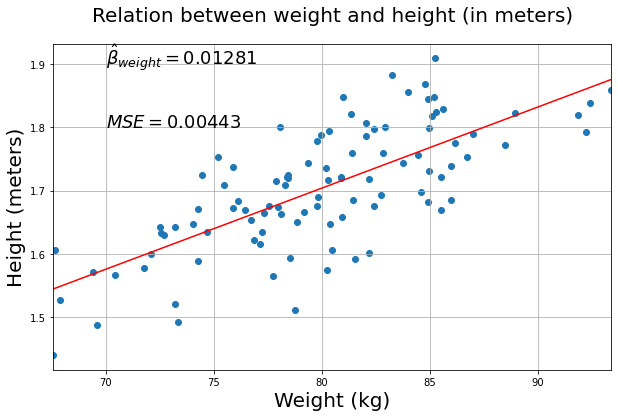

In [30]:
data = np.load('data/weight_height_data.npz')
X, y = data['X'], data['y']

#Create and estimate the model
Xn = np.hstack((np.ones((y.size, 1)), X))
beta = inv(Xn.T @ Xn) @ Xn.T @ y
y_hat = Xn @ beta
mse = np.mean((y_hat - y) ** 2)

#Plot scatter model
plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.title('Relation between weight and height (in meters)', y=1.05, fontsize=20)
plt.xlabel('Weight (kg)', fontsize=20)
plt.ylabel('Height (meters)', fontsize=20)

#Add model parameters
plt.plot([X.min(), X.max()], [Xn.min(axis=0) @ beta, Xn.max(axis=0) @ beta], ls='-', c='r')
plt.xlim((X.min(), X.max()))
plt.text(70, 1.9, r'$\hat{\beta}_{weight} = %.5f$' % beta[1], fontsize=18)
plt.text(70, 1.8, r'$MSE = %.5f$' % mse, fontsize=18)
plt.grid()

plt.show()

### Beta estimates can only be interpreted in reference to the error and scale.
One could intuitively think that this is a quite small beta-parameter, but the beta always have to be interpreted in reference to the Mean Squared Error, which is also quite low. A large beta may not mean anything if the error is very large, and a small beta may be significant, if the error is also small.

Now, to illustrate the problem of interpretating 'raw' beta-weights, let's rephrase our objective of predicting height based on weight: we'll try to predict *height in centimeters* based on weight (still in kilos). So, what we'll do is just rescale the data points of $\mathbf{y}$ (height in meters) so that they reflect height in centimeters. We can simply do this by multipling our $\mathbf{y}$ by 100.

In [31]:
y_cm = y * 100

Now, you wouldn't expect our model to change, right? We only rescaled our target ... As you'll see below, this actually changes a lot!

In [32]:

beta_cm = inv(Xn.T @ Xn) @ Xn.T @ y_cm
y_hat_cm = Xn @ beta_cm
mse_cm = np.mean((y_hat_cm - y_cm) ** 2)

print("Beta cm:",beta_cm)
print("MSE cm:",mse_cm)

Beta cm: [[67.88037704]
 [ 1.28134464]]
MSE cm: 44.31965034401705


When you compare the beta-parameters between the two models (one where $y$ is in meters, and one where $y$ is in centimeters), you see a massive difference &mdash; a 100 fold difference to be exact\*! This is a nice example where you see that the (raw) value of the beta-parameter is completely dependent on the scale of your variables. (Actually, you could either rescale $\mathbf{X}$ or $\mathbf{y}$); both will have a similar effect on your estimated beta-parameter.)

<div class='alert alert-info'>
    <b>ToThink1</b>: Note that the MSE is a 10,000 times larger in the model with <tt>y_cm</tt> compared to <tt>y</tt> (in meters). From your understanding of how MSE is calculated, do you understand why?
</div>

Write your ToThink1 answer here:

<div class='alert alert-info'>
<b>ToThink2</b>: By now, you know that the scale of the data (either $X$ or $y$) influences the magnitude of the raw parameter estimates. One could argue that this is not relevant for fMRI data because all data (i.e. different voxels in the brain) all measure the same type of signal, so their scale shouldn't differ that much. This, however, is a false assumption.

Think of (at least) two reasons why voxels might differ in their scale and write them down in the text cell below.
</div>

Write your ToThink2 answer here:

## How to compute *t*-values and *p*-values
So, you've seen that interpreting beta-parameters by themselves is useless because their value depends very much on the scale of your variables. But how should we, then, interpret the effects of our predictors on our target-variable? From the plots above, you probably guessed already that it has something to do with the MSE of our model (or, more generally, the model fit). That is indeed the case. As you might have noticed, not only the beta-parameters depend on the scale of your data, the errors (residuals) depend on the scale as well. In other words, not only the *effect* (beta-values) but also the *noise* (errors, MSE) depend on the scale of the variables! 

### *t*-values
In fact, the key to getting interpretable effects of our predictors is to divide ("normalize") our beta-parameter(s) by some quantity that summarizes how well our model describes the data. This quantity is the **standard error of the beta-parameter**, usually denoted by $\mathrm{SE}_{\beta}$. The standard error of the beta-parameter can be computed by taking the square root of the **variance of the beta-parameter**. If we'd divide our beta-estimate with it's standard error, we compute a statistic you are all familiar with: the *t*-statistic! Formally:

\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}}{\mathrm{SE}_{\hat{\beta}}} = \frac{\hat{\beta}}{\sqrt{\mathrm{var}(\hat{\beta})}}
\end{align}

<div class='alert alert-info'>
    <b>ToThink3</b>: Suppose that I know the $\mathrm{SE}$ of a particular beta-parameter. How can I derive the variance of that parameter (i.e., how do I go from the $\mathrm{SE}$ to the variance)? And yes, the answer is as straightforward as you'd think.
</div>

Write your ToThink2 answer here:

<b>Another way to think about it</b> is that the t-value is the "effect" ($\hat{\beta}$) divided by your (un)certainty or confidence in the effect ($\mathrm{SE}_{\hat{\beta}}$). In a way, you can think of t-values as "uncertainty-normalized" effects.

So, what drives (statistical) uncertainty about "effects" (here: $\hat{\beta}$ parameters)? To find out, let's dissect the uncertainty term, $\mathrm{SE}_{\hat{\beta}}$, a little more. The standard error of a parameter can interpreted conceptually as the "unexplained variance of the model" (or *noise*) multiplied with the "design variance" (or: *the variance of the parameter due to the design*). In this lab, we won't explain what *design variance* means or how to compute this, as this is the topic of the second notebook of this week (`design_of_experiments`).

For now, we treat "design variance", here, as some known (constant) value given the design matrix ($\mathbf{X}$). So, with this information, we can construct a conceptual formula for the standard error of our parameter(s):

\begin{align}
\mathbf{SE}_{\hat{\beta}} = \sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}
\end{align}

Now we also create a "conceptual formula" for the *t*-statistic:

\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}}{\mathrm{SE}_{\hat{\beta}}} = \frac{\mathrm{effect}}{\sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}}
\end{align}

**This (conceptual) formula involving effects, noise, and design variance is probably the most important concept of this course**. The effects (*t*-values) we measure in GLM analyses of fMRI data depend on two things: the effect measured ($\hat{\beta}$) and the (un)certainty of the effect ($SE_{\hat{\beta}}$), of which the latter term can be divided into the unexplained variance ("noise") and the design variance (uncertainty of the parameter due to the design).

These two terms (noise and design variance) will be central to the next couple of weeks of this course. In this week's second notebook (topic: design of experiments), we'll focus on how to optimize our *t*-values by minimizing the "design variance" term. Next week (topic: preprocessing), we'll focus on how to (further) optimize our *t*-values by minimizing the error/noise.

While we're going to ignore the design variance for now, we are, however, going to learn how to calculate the "noise" term.

In fact, the noise term is *very* similar to the MSE, but instead of taking the *mean* of the squared residuals, we sum the squared residuals ("sums of squared erros", SSE) and divide it by the model's degrees of freedom (DF). People usually use the $\hat{\sigma}^{2}$ symbol for this noise term:

\begin{align}
\mathrm{noise} = \hat{\sigma}^{2} = \frac{\sum_{i=1}^{N}(\hat{y_{i}} - y_{i})^2}{\mathrm{df}} 
\end{align}

where the degrees of freedom (df) are defined as the number of samples ($N$) minus the number of predictors *including the intercept* ($P$):

\begin{align}
\mathrm{df} = N - P
\end{align}

So, the formula of the *t*-statistic becomes:

\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}}{\sqrt{\frac{\sum_{i=1}^{N}(\hat{y_{i}} - y_{i})^2}{N - P} \cdot \mathrm{design\ variance}}}
\end{align}

Alright, enough formulas. Let's see how we can compute these terms in Python. We're going to calculate the *t*-statistic of the weight-predictor for both models (the meter and the centimeter model) to see whether we can show that essentially the (normalized) effect of weight on height in meters is the same as the effect on height in centimeters; in other words, we are going to investigate whether the conversion to *t*-values "normalizes" the beta-parameters.

First, we'll create a function for you to calculate the design-variance. You *don't* have to understand how this works; we're going to explain this in another tutorial.

In [33]:
def design_variance(X, which_predictor=1):
    ''' Returns the design variance of a predictor (or contrast) in X.
    
    Parameters
    ----------
    X : numpy array
        Array of shape (N, P)
    which_predictor : int or list/array
        The index of the predictor you want the design var from.
        Note that 0 refers to the intercept!
        Alternatively, "which_predictor" can be a contrast-vector
        (which will be discussed later this lab).
        
    Returns
    -------
    des_var : float
        Design variance of the specified predictor/contrast from X.
    '''
    
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0
    
    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

So, if you want the design variance of the 'weight' parameter in the varianble `Xn` from before, you do:

In [34]:
# use which_predictor=1, because the weight-column in Xn is at index 1 (index 0 = intercept)
design_variance_weight_predictor = design_variance(Xn, which_predictor=1)
print("Design variance of weight predictor is: %.6f " % design_variance_weight_predictor)

Design variance of weight predictor is: 0.000334 


Alright, now we only need to calculate our noise-term ($\hat{\sigma}^2$):

In [35]:
# Let's just redo the linear regression (for clarity)
beta_meter = inv(Xn.T @ Xn) @ Xn.T @ y
y_hat_meter = Xn @ beta_meter

#How many data points?
N = y.size
#How many parameters in the model?
P = Xn.shape[1]
#How many degrees of freedom?
df = (N - P)
print("Degrees of freedom: %i" % df)
sigma_hat = np.sum((y - y_hat_meter) ** 2) / df
print("Sigma-hat (noise) is: %.3f" % sigma_hat)
design_variance_weight = design_variance(Xn, 1)

Degrees of freedom: 98
Sigma-hat (noise) is: 0.005


Now we can calculate the *t*-value:

In [36]:
t_meter = beta_meter[1] / np.sqrt(sigma_hat * design_variance_weight)
print("The t-value for the weight-parameter (beta = %.3f) is: %.3f" % (beta_meter[1], t_meter))

The t-value for the weight-parameter (beta = 0.013) is: 10.431


That's it! There's not much more to calculating *t*-values in linear regression. Now it's up to you to do the same thing and calculate the *t*-value for the model of height in centimeters, and check if it is the same as the *t*-value for the weight parameter in the model with height in meters.

<div class='alert alert-warning'>
    <b>ToDo1</b>: Calculate the <em>t</em>-statistic for the beta from the centimeter-model you calculated earlier. Store the value in a new variable named <tt>t_centimeter</tt>. Note: you don't have to calculate the design variance again (because <tt>X</tt> hasn't changed!) &mdash; you can reuse the variable <tt>design_variance_weight</tt>.
</div>

In [37]:

### Implement solution for ToDo1 here


### P-values
As you can see, calculating *t*-values solves the "problem" of uninterpretable beta-parameters!

Now, the last thing you need to know is how to calculate the statistical significance of your *t*-value, or in other words, how you calculate the corresponding *p*-value. You probably remember that the *p*-value corresponds to the area under the curve of a *t*-distribution associated with your observed *t*-value *and more extreme values*: 
![test](http://www.nku.edu/~statistics/Test_o12.gif)
*Image credits: Frank Dietrich and Mike Collins, Northern Kentucky University*

The function `stats.t.sf(t_value, df)` from the `scipy` package does exactly this. Importantly, this function *always* returns the right-tailed p-value. For negative t-values, however, you'd want the left-tailed *p*-value. One way to remedy this, is to always pass the absolute value of your *t*-value - `np.abs(t_value)` to the `stats.t.sf()` function. Also, the `stats.t.sf()` function by default returns the one-sided *p*-value. If you'd want the two-sided *p*-value, you can simply multiply the returned *p*-value by two to get the corresponding two-sided *p*-value. 

Let's see how we'd do that in practice:

In [38]:
from scipy import stats

# take the absolute by np.abs(t)
p_value = stats.t.sf(np.abs(t_meter), df) * 2 # multiply by two to create a two-tailed p-value
print('The p-value corresponding to t(%i) = %.3f is: %.8f' % (df, t_meter, p_value))

The p-value corresponding to t(98) = 10.431 is: 0.00000000


## Contrasts
We're almost done! We're really at 99% of what you should know about the GLM and fMRI analysis (except for some important caveats that have to do with GLM assumptions, that we'll discuss next week). The only major concept that we need to discuss is **contrasts**. Contrasts are basically follow-up statistical tests of GLM parameters, with which you can implement any (linear) statistical test that you are familiar with. *t*-tests, *F*-tests, ANCOVAs &mdash; they can all be realized with the GLM and the right contrast(s). (Again, if you want to know more about this equivalence between the GLM and common statistical tests, check out this [blog post](https://lindeloev.github.io/tests-as-linear/).) Importantly, the choice of contrast should reflect the hypothesis that you want to test.

### *t*-tests
T-tests in the GLM can be implemented in two general ways:

**1. Using a contrast of a parameters "against baseline"**

This type of contrast basically tests the hypothesis: "Does my predictor(s) have *any* effect on my dependent variable?" In other words, it tests the following hypothesis:
* $H_{0}: \beta = 0$        (our null-hypothesis, i.e. no effect)
* $H_{a}: \beta \neq 0$     (our two-sided alternative hypothesis, i.e. *some* effect)

Note that a directional alternative hypothesis is also possible, i.e., $H_{a}: \beta > 0$ or $H_{a}: \beta < 0$.

**2. Using a contrast between parameters**

This type of contrast basically tests hypotheses such as "Does predictor 1 have a larger effect on my dependent variable than predictor 2?". In other words, it tests the following hypothesis:
* $H_{0}: \beta_{1} - \beta_{2} = 0$ (our null-hypothesis, i.e. there is no difference)
* $H_{a}: \beta_{1} - \beta_{2} \neq 0$     (our alternative hypotehsis, i.e. there is some difference)

Let's look at an example of how we would evaluate a simple hypothesis that a beta has an *some* effect on the dependent variable. Say we'd have an experimental design with 6 conditions:

* condition 1: images of **male** faces with a **happy** expression
* condition 2: images of **male** faces with a **sad** expression
* condition 3: images of **male** faces with a **neutral** expression
* condition 4: images of **female** faces with a **happy** expression
* condition 5: images of **female** faces with a **sad** expression
* condition 6: images of **female** faces with a **neutral** expression

Let's assume we have fMRI data from a run with 100 volumes. We then have a target-signal of shape ($100,$) and a design-matrix (after convolution with a canonical HRF) of shape ($100 \times 7$) (the first predictor is the intercept!). We load in this data below:

In [39]:
data = np.load('data/data_contrast_example.npz')
X, y = data['X'], data['y']

print("Shape of X: %s" % (X.shape,))
print("Shape of y: %s" % (y.shape,))

Shape of X: (100, 7)
Shape of y: (100,)


After performing linear regression with these 6 predictors (after convolving the stimulus-onset times with an HRF, etc. etc.), you end up with 7 beta values:

In [40]:
betas = inv(X.T @ X) @ X.T @ y
betas = betas.squeeze()  # remove singleton dimension; this is important for later
print("Betas corresonding to our 6 conditions (and intercept):\n%r" % betas.T)

Betas corresonding to our 6 conditions (and intercept):
array([ 0.08208567, -0.21982422, -0.16284892,  0.53208935,  0.26214462,
        0.38945094,  0.21565532])


The first beta corresponds to the intercept, the second beta to the male/happy predictor, the third beta to the male/sad predictor, etc. etc. Now, suppose that we'd like to test whether images of male faces with a sad expression have an influence on voxel activity (our dependent variable). 

The first thing you need to do is extract this particular beta value from the array with beta values (I know this sounds really trivial, but bear with me):

In [41]:
beta_male_sad = betas[2]
print("The 'extracted' beta is %.3f" % beta_male_sad)

The 'extracted' beta is -0.163


In neuroimaging analyses, however, this is usually done slightly differently: using **contrast-vectors**. Basically, it specifies your specific hypothesis about your beta(s) of interest in a vector. Before explaining it in more detail, let's look at it in a code example:

In [42]:
# Again, we'd want to test whether the beta of "male_sad" is different from 0
contrast_vector = np.array([0, 0, 1, 0, 0, 0, 0])
contrast = (betas * contrast_vector).sum() # we simply elementwise multiply the contrast-vector with the betas and sum it!
print('The beta-contrast is: %.3f' % contrast)

The beta-contrast is: -0.163


"Wow, what a tedious way to just select the third value of the beta-array", you might think. And, in a way, this is indeed somewhat tedious for a contrast against baseline. But let's look at a case where you would want to investigate whether two betas are different - let's say whether male sad faces have a larger effect on our voxel than male happy faces. Again, you *could* do this:

In [43]:
beta_difference = betas[2] - betas[1]
print("Difference between betas: %.3f" % beta_difference)

Difference between betas: 0.057


... but you could also use a contrast-vector:

In [44]:
contrast_vector = np.array([0, -1, 1, 0, 0, 0, 0])
contrast = (betas * contrast_vector).sum()
print('The contrast between beta 2 and beta 1 is: %.3f' % contrast)
print('This is exactly the same as beta[2] - beta[1]: %.3f' % (betas[2]-betas[1]))

The contrast between beta 2 and beta 1 is: 0.057
This is exactly the same as beta[2] - beta[1]: 0.057


"Alright, so using contrast-vectors is just a fancy way of extracting and subtracting betas from each other ...", you might think. In a way, that's true. But you have to realize that once the hypotheses you want to test become more complicated, using contrast-vectors actually starts to make sense.

Let's look at some more elaborate hypotheses. First, let's test whether male faces lead to higher voxel activity than female faces, *regardless of emotion*:

In [45]:
# male faces > female faces
contrast_vector = [0, 1, 1, 1, -1, -1, -1]
male_female_contrast = (contrast_vector * betas).sum()
print("Male - female contrast (regardless of expression): %.2f" % male_female_contrast)

Male - female contrast (regardless of expression): -0.72


... or whether emotional faces (regardless of *which* exact emotion) lead to higher activity than neutral faces:

In [46]:
# Emotion (regardless of which emotion, i.e., regardless of sad/happy) - neutral
contrast_vector = np.array([0, 1, 1, -2, 1, 1, -2])
emo_neutral_contrast = (contrast_vector * betas).sum()
print("Emotion - neutral contrast (regardless of which emotion): %.2f" % emo_neutral_contrast)

Emotion - neutral contrast (regardless of which emotion): -1.23


See how contrast-vectors come in handy when calculating (more intricate) comparisons? In the male-female contrast, for example, instead 'manually' picking out the betas of 'sad_male' and 'happy_male', averaging them, and subtracting their average beta from the average 'female' betas ('happy_female', 'sad_female'), you can 
specify a contrast-vector, multiply it with your betas, and sum them. That's it.

<div class='alert alert-info'>
<b>ToThink4</b>: In the last contrast (<tt>emo_neural_contrast</tt>), we set all the "emotional" predictors (sad/happy) to 1, but the neutral predictors to minus <em>2</em> ... Why are these set to -2 and not -1? Write your answer below.
</div>

Write your ToThink4 answer here:

<div class='alert alert-warning'>
<b>ToDo2</b>: Create a contrast vector for the hypothesis: sad faces (regardless whether it's male or female) activate this voxel more than neutral faces (regardless of whether it's male/female). Multiply this contrast vector with the betas and store the result in a variable named <tt>contrast_todo</tt>.
</div>

In [47]:
# Implement the sad - neutral contrast here:



We're not only telling you about contrasts because we think it's an elegant way of computing beta-comparisons, but also because virtually every major neuroimaging software package uses them, so that you can specify what hypotheses you exactly want to test! You'll also see this when we're going to work with FSL (in week 5) to perform automated whole-brain linear regression analyses.

Knowing how contrast-vectors work, we now can extend our formula for *t*-tests of beta-parameters such that they can describe **every possible test** (not only *t*-tests, but also ANOVAs, *F*-tests, etc.) of betas "against baseline" or between betas that you can think of: 

Our "old" formula of the *t*-test of a beta-parameter:
\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}_{j}}{\mathrm{SE}_{\hat{\beta}}}
\end{align}

And now our "generalized" version of the *t*-test of *any* contrast/hypothesis:

\begin{align}
t_{\mathbf{c}\hat{\beta}} = \frac{\sum_{j=1}^{P}{c_{j}\hat{\beta}_{j}}}{\mathrm{SE}_{\mathbf{c}\hat{\beta}}} 
\end{align}

in which $\mathbf{c}$ represents the entire contrast-vector, and $c_{j}$ represents the $j^{\mathrm{th}}$ value in our contrast vector. By the way, we can simplify the (notation of the) numerator a little bit using some matrix algebra. Remember that multiplying two (equal length) vectors with each other and then summing the values together is the same thing as the (inner) "dot product" between the two vectors? 

This means that you can also evaluate this elementwise multiplication and sum of the contrast-vector and the betas using the dot-product:

\begin{align}
t_{\mathbf{c}\hat{\beta}} = \frac{\mathbf{c}\hat{\beta}}{\mathrm{SE}_{\mathbf{c}\hat{\beta}}} 
\end{align}

So, you need the contrast vector in the *numerator* of the *t*-value formula (i.e., $\mathbf{c}\hat{\beta}$), but it turns out that you actually also need the contrast-vector in the denominator, because it's part of the calculation of design variance. Again, we will discuss how this works exactly in the next notebook. In the function `design_variance`, it is also possible to calculate design variance for a particular contrast (not just a single predictor) by passing a contrast vector to the `which_predictor` argument.

We'll show this below:

In [48]:
# E.g., get design-variance of happy/male - sad/male
c_vec = np.array([0, 1, -1, 0, 0, 0, 0])  # our contrast vector!
dvar = design_variance(X, which_predictor=c_vec)  # pass c_vec to which_predictor
print("Design variance of happy/male - sad/male: %.3f" % dvar)

Design variance of happy/male - sad/male: 0.024


<b> Another Example: Sad faces > happy faces </b>
    
Let's calculate the *t*-value and *p*-value for the hypothesis "sad faces have a larger effect than happy faces (regardless of gender) on our dependent variable" (i.e. voxel activity). In other words, test the hypothesis: $\beta_{sad} - \beta_{happy} \neq 0$ (note that this is a two-sided test!).

Store the *t*-value and *p*-value in the variables <tt>tval_todo</tt> and <tt>pval_todo</tt> respectively. We reload the variables below (we'll call them <tt>X_new</tt> and <tt>y_new</tt>) to make sure we're working with the correct data. Note that the <tt>X_new</tt> variable already contains an intercept; the other six columns correspond to the different predictors (male/hapy, male/sad, etc.). In summary, we will do the following:

- (We don't have to calculate the betas; this has already been done (stored in the variable <tt>betas</tt>)
- calculate "sigma-hat" ($\mathrm{SSE} / \mathrm{df}$)
- calculate design-variance (use the <tt>design_variance</tt> function with a proper contrast-vector)
- calculate the contrast ($\mathbf{c}\hat{\beta}$)
- calculate the t-value and p-value
</div>

In [49]:
data = np.load('data/data_contrast_example.npz')
X_new, y_new = data['X'], data['y']

print("Shape of X: %s" % (X_new.shape,))
print("Shape of y: %s" % (y_new.shape,))

#The contrast vector for sad>happy
cvec = np.array([0, -1, 1, 0, -1, 1, 0])
#The design variance for this particular contrast
this_dvar = design_variance(X, cvec)
#Calculating predicted values
y_hat = X_new.dot(betas)


this_sse = ((y_new - y_hat) ** 2).sum() / (X.shape[0] - X.shape[1])
#t-value
tval_SadHap = cvec.dot(betas) / np.sqrt(this_sse * this_dvar)
#p-value
pval_SadHap = stats.t.sf(np.abs(tval_SadHap), (X_new.shape[0] - X_new.shape[1])) * 2

print("t=", tval_HapSad)
print("p=",pval_HapSad)

Shape of X: (100, 7)
Shape of y: (100,)
t= 1.2645629707362722
p= 0.20918791772294118


### *F*-tests on contrasts
In the previous section we discussed how to calculate *t*-values for single contrasts. However, sometimes you might have a hypothesis about multiple contrasts at the same time. This may sound weird, but let's consider an experiment.

Suppose you have data from an experiment in which you showed images circles which were either blue, red, or green. In that case, you have three predictors. Then, you could have very specific question, like "Do blue circles activate a voxel significantly compared to baseline", which corresponds to the following null and alternative hypothesis:

* $H_{0}: \beta_{blue} = 0$ (our null-hypothesis, i.e. there is no activation compared to baseline)
* $H_{a}: \beta_{blue} > 0$   (our alternative hypothesis, i.e. blue activates relative to baseline)

However, you can also have a more general question, like "Does the presentation of *any* circle (regardless of color) activate a voxel compared to baseline?". This question represents the following null and alternative hypothesis:

* $H_{0}: \beta_{blue} = \beta_{red} = \beta_{green} = 0$
* $H_{a}: (\beta_{blue} > 0) \vee (\beta_{red} > 0) \vee (\beta_{green} > 0)$

The $\vee$ symbol in the alternative hypothesis means "or". So the alternative hypothesis nicely illustrates our question: is there *any* condition (circle) that activates a voxel more than baseline? This hypothesis-test might sound familiar, because it encompasses the *F*-test! In other words, an *F*-test tests *a collection of contrasts* together. In the example here, the *F*-test tests the following contrasts together (ignoring the intercept) of our beta-parameters:

* `[1, 0, 0]` ($\mathrm{red} > 0$)
* `[0, 1, 0]` ($\mathrm{blue} > 0$)
* `[0, 0, 1]` ($\mathrm{green} > 0$)

Thus, a *F*-test basically tests this contrast-*matrix* all at once! Therefore, the *F*-tests is a type of "omnibus test"! 

Now, let's look at the math behind the *F*-statistic. The *F*-statistic for set of $K$ contrasts (i.e., the number of rows in the contrast-matrix) is defined as follows:

\begin{align}
F = (\mathbf{c}\hat{\beta})^{T}[K\mathbf{c}((X^{T}X)^{-1}\hat{\sigma}^{2})\mathbf{c}^{T}]^{-1}(\mathbf{c}\hat{\beta})
\end{align}

With a little imagination, you can see how the *F*-test is an extension of the *t*-test of a single contrast to accomodate testing a set of contrasts together. Don't worry, you don't have to understand how the formula for the *F*-statistic works mathematically and you don't have to implement this in Python. But you *do* need to understand what type of hypothesis an *F*-test tests! 

Let's practice this in a ToDo!

<div class='alert alert-warning'>
<b>ToDo3</b>
    
Remember the temporal basis sets from before? Suppose we have an experiment with two conditions ("A" and "B") and suppose we've created a design matrix based on convolution with a single-gamma basis set (with a canonical HRF, its temporal derivative, and its dispersion derivative). Together with the intercept, the design matrix thus has 7 columns (2 conditions * 3 HRF + intercept).

The order of the columns is as follows:
* column 1: intercept
* column 2: canonical HRF "A"
* column 3: temporal deriv "A"
* column 4: dispersion deriv "A"
* column 5: canonical HRF "B"
* column 6: temporal deriv "B"
* column 7: dispersion deriv "B"

Suppose I want to test whether there is *any* difference in response to condition "A" ($A > 0$) compared to baseline, and *I don't care what element of the HRF caused it*. I can use an F-test for this. What would the corresponding contrast-*matrix* (in which each row represents a different contrast) look like? 

We've created an 'empty' (all-zeros) 2D matrix below with three rows. It's up to you to fill in the matrix such that it can be used to test the above question/hypothesis.
</div>

In [50]:
# Fill in the correct values!
contrast_matrix = np.array([

    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]

])

### BEGIN SOLUTION


### Summary
Alright, now you know basically everything about how to perform a univariate fMRI analysis! 

"Wait, that's it?", you might ask (or not). Well, yeah, regular univariate analyses as you might read about in scientific journals do basically what you've just learned, but then not on a single voxel, but on each voxel in the brain separately. Basically just a gigantic for-loop across voxels in which everytime the same design ($\mathbf{X}$) is used to predict a new voxel-signal ($\mathbf{y}$). Afterwards, the *t*-values of the contrast (hypothesis) you're interested in are plotted back onto a brain, color-code it (high t-values yellow, low t-values red), and voilà, you have your pretty brain plot.
![img](https://upload.wikimedia.org/wikipedia/commons/archive/4/4a/20171016185711%211206_FMRI.jpg)
*Image credits: Wikimedia*


<div class='alert alert-info'>
    <b>ToThink4</b>: More explained variance (i.e., a smaller "sums of squared error" term) does not always mean that your <em>t</em>-value is higher. Explain how this might happen.
</div>

Insert your answer to ToThink4 here:

<div class='alert alert-warning'>
    <b>ToDo4</b>: Suppose that, within the hypothesized face-experiment explained earlier, you want to know which parts of the brain show (significantly) more activity during periods without stimuli (i.e., no faces were shown, i.e., "rest") than during periods with stimuli. Define a contrast vector which would test this hypothesis and store it in a variable <tt>cvec_rest</tt>. Remember: the original face experiment had 7 predictors (the first one being the intercept, followed by 6 face predictors).
</div>

In [51]:
# Implement the assignment here

### BEGIN SOLUTION

### END SOLUTION


<div class='alert alert-success'>
    
    
<b>SOLUTIONS</b>
    
    
</div>


<div class='alert alert-info'>
    <b>Solution to ToThink1</b>: Note that the MSE is a 10,000 times larger in the model with <tt>y_cm</tt> compared to <tt>y</tt> (in meters). From your understanding of how MSE is calculated, do you understand why?
</div>

The MSE is squared error. 100 x 100 =10,000

<div class='alert alert-info'>
<b>Solution for ToThink2</b>:
</div>

1. Inhomogeneity of the signal at some spots (lower signal)
2. Type of scanner.
3. Different tissue types (white matter, gray matter, CSF, mix)
4. Closeness to the headcoil (subcortical structures for example have generally a lower SNR)

<div class='alert alert-info'>
    <b>Solution for ToThink3</b>:
</div>

Square it: SE(beta)^2 = var(beta)

<div class='alert alert-warning'>
    <b>Solution for ToDo1</b>:
</div>

In [ ]:

beta_cm = inv(Xn.T @ Xn) @ Xn.T @ y_cm
y_hat_cm = Xn @ beta_cm
sse_cm = ((y_hat_cm - y_cm) ** 2).sum()
se_cm = np.sqrt(sse_cm / df * design_variance_weight)
t_centimeter = beta_cm[1] / se_cm
print("t-value for centimeter model:", t_centimeter)

<div class='alert alert-info'>
<b>Solution for ToThink4</b>:
</div>

They have to sum to 0. If you'd use -1, you would "weigh" the emotional predictors twice as heavy as the neutral predictors.

<div class='alert alert-warning'>
<b>Solution for ToDo2</b>:.
</div>

In [ ]:

cvec = np.array([0, 0, 1, -1, 0, 1, -1])
contrast_todo = cvec @ betas


<div class='alert alert-warning'>
<b>Solution for ToDo3:</b>

</div>

In [53]:
# Fill in the correct values!
contrast_matrix = np.array([

    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]

])

### BEGIN SOLUTION
contrast_matrix = np.array([
    
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0]

])
### END SOLUTION

<div class='alert alert-info'>
    <b>Solution for ToThink4</b>:
</div>

The noise term of the *t*-value is the sum of squared errors *divided by the degrees of freedom*. So with fewer degrees of freedom, everything else being equal, the noise term will increase. So in situations with (a lot of) predictors that explain little to no variance, including those might actually increase the noise term and the decrease *t*-values.

<div class='alert alert-warning'>
    <b>Solution for ToDo4</b>:
</div>

In [51]:
# Implement the assignment here

### BEGIN SOLUTION
# We are looking for areas that have more signal when there is not a face stimulus. We can find this by multiplying the face predictors with -1.

cvec_rest = np.array([0, -1, -1, -1, -1, -1, -1])
### END SOLUTION


<div class='alert alert-success'>
    
    
<b>END OF SOLUTIONS</b>
    
    
</div>
